# WESAD
###  A Multimodal Dataset for Wearable Stress and Affect Detection

##### Matthew Johnson, 2019

===============================================================================================================


### Dataset Information [1]:
Data Set Information:

WESAD is a publicly available dataset for wearable stress and affect detection. This multimodal dataset features physiological and motion data, recorded from both a wrist- and a chest-worn device, of 15 subjects during a lab study. The following sensor modalities are included: blood volume pulse, electrocardiogram, electrodermal activity, electromyogram, respiration, body temperature, and three-axis acceleration. Moreover, the dataset bridges the gap between previous lab studies on stress and emotions, by containing three different affective states (neutral, stress, amusement). In addition, self-reports of the subjects, which were obtained using several established questionnaires, are contained in the dataset. Details can be found in the dataset's readme-file, as well as in [1].


Attribute Information:

Raw sensor data was recorded with two devices: a chest-worn device (RespiBAN) and a wrist-worn device (Empatica E4). 
The RespiBAN device provides the following sensor data: electrocardiogram (ECG), electrodermal activity (EDA), electromyogram (EMG), respiration, body temperature, and three-axis acceleration. All signals are sampled at 700 Hz. 
The Empatica E4 device provides the following sensor data: blood volume pulse (BVP, 64 Hz), electrodermal activity (EDA, 4 Hz), body temperature (4 Hz), and three-axis acceleration (32 Hz). 

The dataset's readme-file contains all further details with respect to the dataset structure, data format (RespiBAN device, Empatica E4 device, synchronised data), study protocol, and the self-report questionnaires.


- https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29



### Classes

**Baseline condition**: 20 minute period of standing/sitting reading magazines.<br>
**Amusement condition**: During the amusement condition, the
subjects watched a set of eleven funny video clips.<br>
**Stress condition**: Trier Social Stress Test (TSST), consisting of public speaking and mental arithmetic.




------------
   
#### References

[1] Schmidt, Philip & Reiss, Attila & Duerichen, Robert & Marberger, Claus & Van Laerhoven, Kristof. (2018). Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection. 400-408. 10.1145/3242969.3242985.  https://dl.acm.org/citation.cfm?doid=3242969.3242985

[2] A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi
"cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing"
IEEE Transactions on Biomedical Engineering, 2015
DOI: 10.1109/TBME.2015.2474131
https://github.com/lciti/cvxEDA

[3] J. Choi, B. Ahmed, and R. Gutierrez-Osuna. 2012. Development and evaluation
of an ambulatory stress monitor based on wearable sensors. IEEE Transactions
on Information Technology in Biomedicine 16, 2 (2012).  
    http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf
    
[6] J. Healey and **R. Picard.** 2005. Detecting stress during real-world driving tasks
using physiological sensors. IEEE Transactions on Intelligent Transportation
Systems 6, 2 (2005), 156–166.  


#### Useful Resources:
- https://github.com/jaganjag/stress_affect_detection
- https://github.com/arsen-movsesyan/springboard_WESAD
- https://www.birmingham.ac.uk/Documents/college-les/psych/saal/guide-electrodermal-activity.pdf
- http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf

 TODO: 
        - add early stopping?
        - maybe change to binary classification (stress, not-stress)?

## Dataset and Dataloading

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix


class WESADDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe.drop('subject', axis=1)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
        
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].values
        y = self.labels[idx]
        return torch.Tensor(x), y

    def __len__(self):
        return len(self.dataframe)

### Cross Validation Loader

In [2]:
feats =   ['BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
           'EDA_phasic_mean', 'EDA_phasic_std', 'EDA_phasic_min', 'EDA_phasic_max', 'EDA_smna_mean',
           'EDA_smna_std', 'EDA_smna_min', 'EDA_smna_max', 'EDA_tonic_mean',
           'EDA_tonic_std', 'EDA_tonic_min', 'EDA_tonic_max', 'Resp_mean',
           'Resp_std', 'Resp_min', 'Resp_max', 'TEMP_mean', 'TEMP_std', 'TEMP_min',
           'TEMP_max', 'TEMP_slope', 'BVP_peak_freq', 'age', 'height',
           'weight','subject', 'label']
layer_1_dim = len(feats) -2
print(layer_1_dim)

29


In [14]:
def get_data_loaders(df, subject_id, train_batch_size=25, test_batch_size=5):
    #df = pd.read_csv('data/m14_merged.csv', index_col=0)[feats]

    train_df = df[ df['subject'] != subject_id].reset_index(drop=True)
    test_df = df[ df['subject'] == subject_id].reset_index(drop=True)
    
    train_dset = WESADDataset(train_df)
    test_dset = WESADDataset(test_df)

    train_loader = torch.utils.data.DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dset, batch_size=test_batch_size)
    
    return train_loader, test_loader

## Network Architecture

In [16]:
class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        self.fc = nn.Sequential(
                        nn.Linear(29, 128),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        #nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(256, 2),
                        #nn.Dropout(0.5),
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)    

## Model Training

In [5]:
def train(model, optimizer, train_loader, validation_loader):
    history = {'train_loss': {}, 'train_acc': {}, 'valid_loss': {}, 'valid_acc': {}}
    #
    for epoch in range(num_epochs):

        # Train:   
        total = 0
        correct = 0
        trainlosses = []

        for batch_index, (images, labels) in enumerate(train_loader):

            # Send to GPU (device)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images.float())

            # Loss
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trainlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

        history['train_loss'][epoch] = np.mean(trainlosses) 
        history['train_acc'][epoch] = correct/total 

        if epoch % 10 == 0:
            with torch.no_grad():

                losses = []
                total = 0
                correct = 0

                for images, labels in validation_loader:
                    # 
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images.float())
                    loss = criterion(outputs, labels)

                    # Compute accuracy
                    _, argmax = torch.max(outputs, 1)
                    correct += (labels == argmax).sum().item() #.mean()
                    total += len(labels)

                    losses.append(loss.item())
                    
                history['valid_acc'][epoch] = np.round(correct/total, 3)
                history['valid_loss'][epoch] = np.mean(losses)

                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')
                
    return history

In [6]:
def test(model, validation_loader):
    print('Evaluating model...')
    # Test
    model.eval()

    total = 0
    correct = 0
    testlosses = []
    correct_labels = []
    predictions = []

    with torch.no_grad():

        for batch_index, (images, labels) in enumerate(validation_loader):
            # Send to GPU (device)
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images.float())

            # Loss
            loss = criterion(outputs, labels)

            testlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

            correct_labels.extend(labels)
            predictions.extend(argmax)


    test_loss = np.mean(testlosses)
    accuracy = np.round(correct/total, 2)
    print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')
    
    y_true = [label.item() for label in correct_labels]
    y_pred = [label.item() for label in predictions]

    cm = confusion_matrix(y_true, y_pred)
    # TODO: return y true and y pred, make cm after ( use ytrue/ypred for classification report)
    # return [y_true, y_pred, test_loss, accuracy]
    return cm, test_loss, accuracy

## Start Here

In [11]:
df = pd.read_csv('data/m14_merged.csv', index_col=0)
subject_id_list = df['subject'].unique()
df.head()

,net_acc_mean,net_acc_std,net_acc_min,net_acc_max,ACC_x_mean,ACC_x_std,ACC_x_min,ACC_x_max,ACC_y_mean,ACC_y_std,...,age,height,weight,gender_ female,gender_ male,coffee_today_YES,sport_today_YES,smoker_NO,smoker_YES,feel_ill_today_YES
0,0.029937,0.009942,0.000000,0.087383,0.029510,0.011145,-0.024082,0.087383,0.000020,0.000008,...,27,175,80,0,1,0,0,1,0,0
1,0.021986,0.015845,0.000000,0.071558,0.017352,0.020817,-0.037843,0.071558,0.000012,0.000014,...,27,175,80,0,1,0,0,1,0,0
2,0.020839,0.011034,0.002752,0.054356,0.020839,0.011034,0.002752,0.054356,0.000014,0.000008,...,27,175,80,0,1,0,0,1,0,0
3,0.034449,0.003185,0.013761,0.040595,0.034449,0.003185,0.013761,0.040595,0.000024,0.000002,...,27,175,80,0,1,0,0,1,0,0
4,0.028870,0.004379,0.013761,0.038531,0.028870,0.004379,0.013761,0.038531,0.000020,0.000003,...,27,175,80,0,1,0,0,1,0,0


In [12]:
def change_label(label):
    if label == 0 or label == 1:
        return 0
    else:
        return 1
    
df['label'] = df['label'].apply(change_label)

In [18]:
df = df[feats]

In [19]:
# Batch sizes
train_batch_size = 25
test_batch_size = 5

# Learning Rate
learning_rate = 5e-3

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of Epochs
num_epochs = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# models = [] # save models at all/ directly?
histories = []
confusion_matrices = []
test_losses = []
test_accs = []

for _ in subject_id_list:
    print('\nSubject: ', _)
    model = StressNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loader, test_loader = get_data_loaders(df, _)
    
    history = train(model, optimizer, train_loader, test_loader)
    histories.append(history)
    
    cm, test_loss, test_acc = test(model, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    confusion_matrices.append(cm)


Subject:  2
Epoch [1/100], Loss: 0.5716, Acc: 0.72
Epoch [11/100], Loss: 0.2584, Acc: 0.92
Epoch [21/100], Loss: 0.1842, Acc: 0.92
Epoch [31/100], Loss: 0.3376, Acc: 0.87
Epoch [41/100], Loss: 0.1826, Acc: 0.93
Epoch [51/100], Loss: 0.1773, Acc: 0.92
Epoch [61/100], Loss: 0.2948, Acc: 0.86
Epoch [71/100], Loss: 0.2625, Acc: 0.92
Epoch [81/100], Loss: 0.2597, Acc: 0.89
Epoch [91/100], Loss: 0.1337, Acc: 0.92
Evaluating model...
Loss: 0.4281, Acc: 0.86

Subject:  3
Epoch [1/100], Loss: 0.5939, Acc: 0.66
Epoch [11/100], Loss: 0.4641, Acc: 0.77
Epoch [21/100], Loss: 0.5787, Acc: 0.78
Epoch [31/100], Loss: 0.4757, Acc: 0.77
Epoch [41/100], Loss: 0.8598, Acc: 0.78
Epoch [51/100], Loss: 0.5116, Acc: 0.81
Epoch [61/100], Loss: 0.9074, Acc: 0.77
Epoch [71/100], Loss: 0.8992, Acc: 0.77
Epoch [81/100], Loss: 1.424, Acc: 0.73
Epoch [91/100], Loss: 1.264, Acc: 0.75
Evaluating model...
Loss: 0.8788, Acc: 0.78

Subject:  4
Epoch [1/100], Loss: 0.4215, Acc: 0.79
Epoch [11/100], Loss: 0.04016, Acc: 1.

In [20]:
np.mean(test_accs)

0.8993333333333333

In [21]:
np.mean(test_losses)

0.34163741094088146

In [25]:
df['label'].value_counts()

0    823
1    355
Name: label, dtype: int64

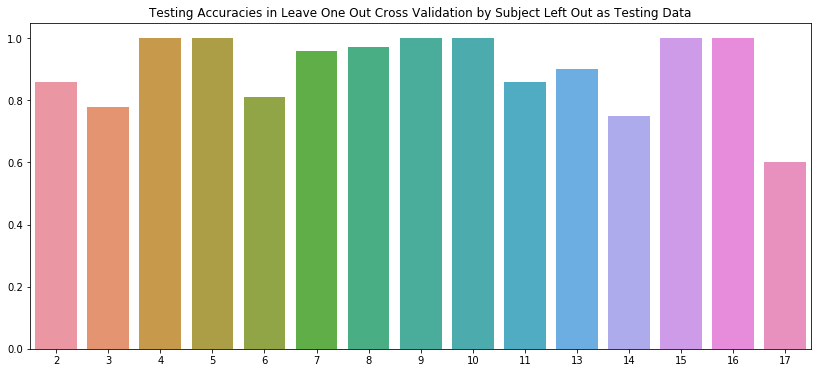

In [22]:
plt.figure(figsize=(14, 6))
plt.title('Testing Accuracies in Leave One Out Cross Validation by Subject Left Out as Testing Data')
sns.barplot(x=subject_id_list, y=test_accs);

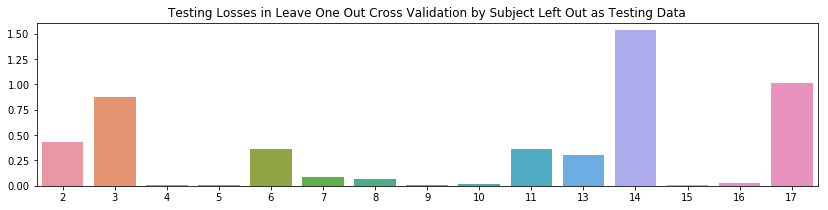

In [23]:
plt.figure(figsize=(14, 3))
plt.title('Testing Losses in Leave One Out Cross Validation by Subject Left Out as Testing Data')
sns.barplot(x=subject_id_list, y=test_losses);

In [16]:
#infodf = pd.read_csv('data/WESAD/readmes.csv', index_col=0)
#infodf.sort_index()

## Training Visualization

In [14]:
len(histories)

15

## Model Evaluation

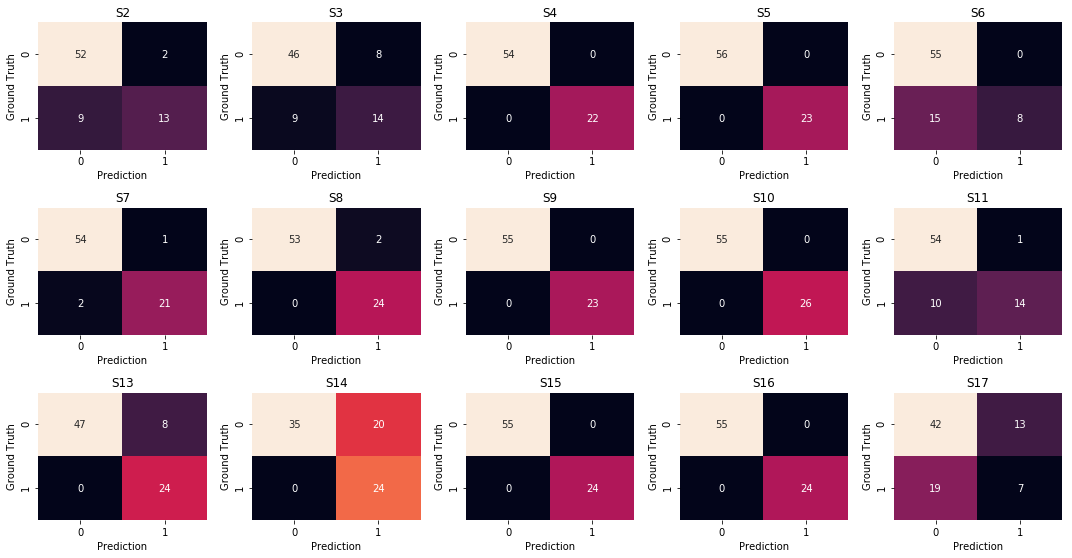

In [26]:
plt.figure(figsize=(15,10))

for i in range(15):
    plt.subplot(4,5 ,i+1)
    cm = confusion_matrices[i]
    
    
    sns.heatmap(cm, annot=True, fmt='d', cbar=False);
    plt.title(f'S{subject_id_list[i]}')
    plt.xlabel('Prediction');
    plt.ylabel('Ground Truth');
plt.tight_layout();

In [16]:
#from sklearn.metrics import classification_report

#target_names = ['Amusement', 'Baseline', 'Stress']
#print(classification_report(y_true, y_pred, target_names=target_names))

In [17]:
#torch.save(model.state_dict(), 'm13_model.pt')